In [1]:
# Imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from wrangle import acquire_wine, wrangle_wine
from vis import quality_distribution, alcohol_distribution, alcohol_vs_quanity, density_vs_quantity, v_acidity_vs_quantity
from explore import spearmanr_test, data_pipeline, bravo_pipeline, feature_selections_results
from model import eval_baseline, train_model, test_model, train_hyper

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor


#set display peferences
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

In [2]:
train, val, test = wrangle_wine()

In [3]:
train.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,type
3761,9.9,0.490,0.23,2.4,0.087,19.0,115.0,0.99480,2.77,0.44,9.400000,6,white
3740,7.7,0.280,0.35,15.3,0.056,31.0,117.0,0.99980,3.27,0.50,9.600000,5,white
1359,11.6,0.475,0.40,1.4,0.091,6.0,28.0,0.99704,3.07,0.65,10.033333,6,red
1230,7.7,0.180,0.34,2.7,0.066,15.0,58.0,0.99470,3.37,0.78,11.800000,6,red
4751,7.6,0.250,1.23,4.6,0.035,51.0,294.0,0.99018,3.03,0.43,13.100000,6,white


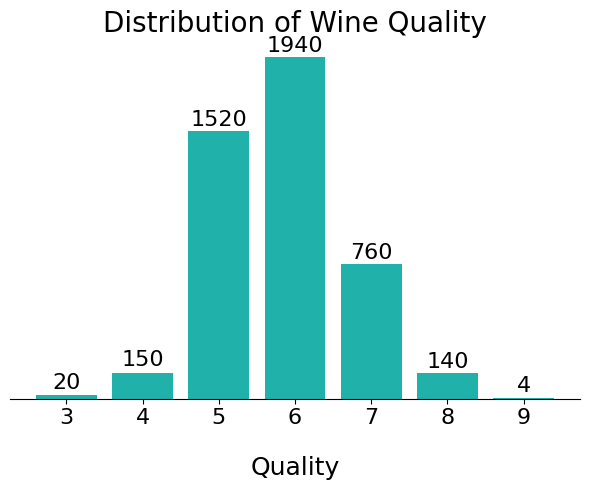

In [4]:
quality_distribution(train)

___
## #1 Alcohol
___

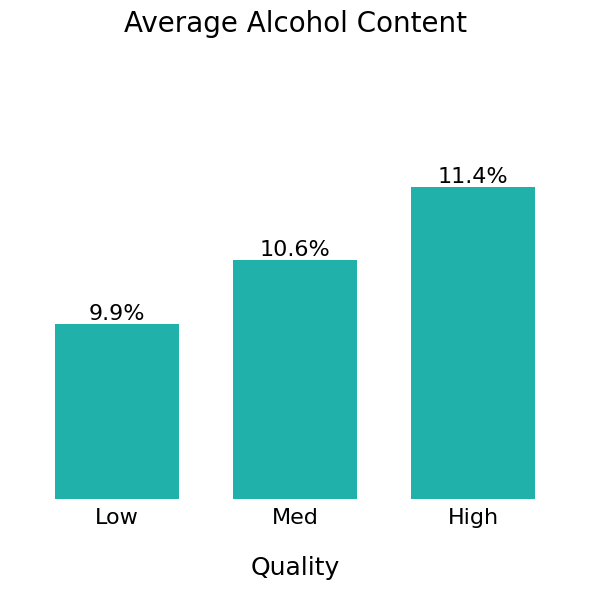

In [5]:
alcohol_vs_quanity(train)

<font size="4"> **Hypothesis 1: Alcohol Content Impact**</font>
   <font size="3"> 
   
   - *Question:* `Does the Alcohol content impact wine Quality?`
   
   </font>

<font size="3"> H0: There is no statistically significant monotonic relationship between the quality of the wine and the alcohol content.</font>

<font size="3">Ha: There is a statistically significant monotonic relationship between the quality of the wine and the alcohol content.</font>

In [6]:
spearmanr_test(train,'alcohol')

There is a statistically significant Spearman's rank correlation (p-value = 0.0000, corr = 0.4471).


<font size="5">We `REJECT` the null hypothesis</font><br>
<font size="4">`There is a relationship` between the `Quality` of the wine and the `Alcohol` content.</font>

___
## #2 Density
___

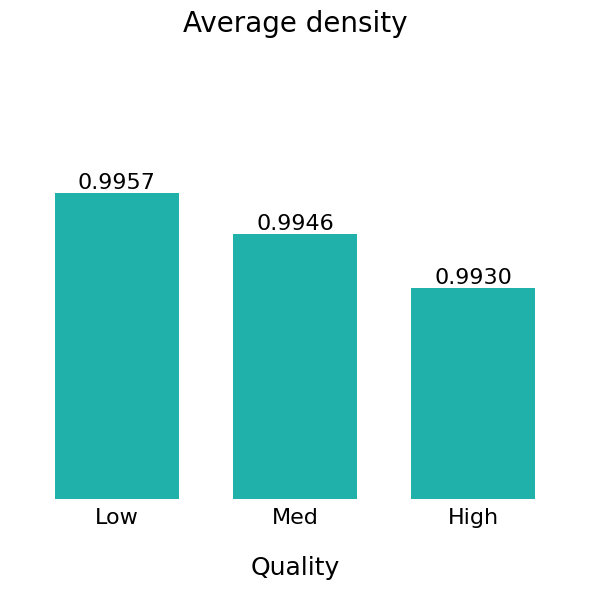

In [7]:
density_vs_quantity(train)

<font size="4"> **Hypothesis 2: Density Impact**</font>
   <font size="3"> 
   
   - *Question:* `Does the Density impact wine Quality?`
   </font>

H0: There is no statistically significant monotonic relationship between the quality of the wine and the density.

Ha: There is a statistically significant monotonic relationship between the quality of the wine and the density.

In [8]:
spearmanr_test(train,'density')

There is a statistically significant Spearman's rank correlation (p-value = 0.0000, corr = -0.3168).


<font size="5">We `REJECT` the null hypothesis</font><br>
<font size="4">`There is a relationship` between the `Quality` of the wine and the `Density`</font>

___
## #3 Volatile Acidity
___

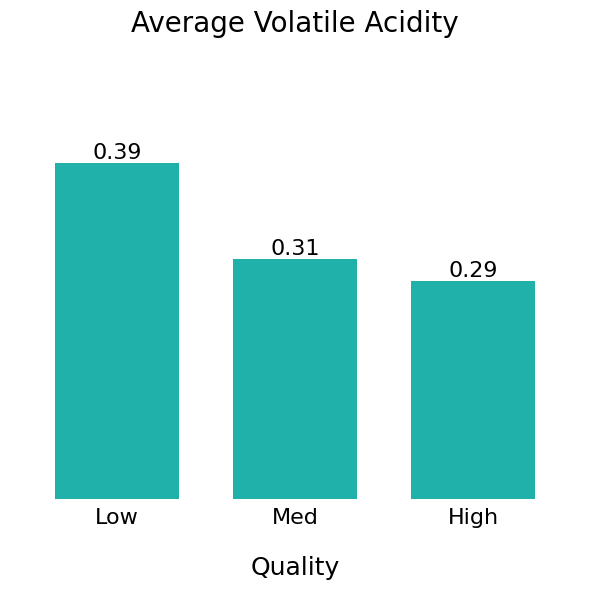

In [9]:
v_acidity_vs_quantity(train)

<font size="4"> **Hypothesis 3: Volatile Acidity Impact**</font>
   <font size="3"> 
   
   - *Question:* `Does the Volatile Acidity impact wine Quality?`
   </font>

H0: There is no statistically significant monotonic relationship between the quality of the wine and the Volatile Acidity.

Ha: There is a sstatistically significant monotonic relationship between the quality of the wine and the Volatile Acidity.

In [10]:
spearmanr_test(train,'volatile_acidity')

There is a statistically significant Spearman's rank correlation (p-value = 0.0000, corr = -0.2609).


<font size="5">We `REJECT` the null hypothesis.</font><br>
<font size="4">`There is a relationship` between the `Quality` of the wine and the `Alcohol` content.</font>

___
## #4 Alcohol+Density Cluster
___

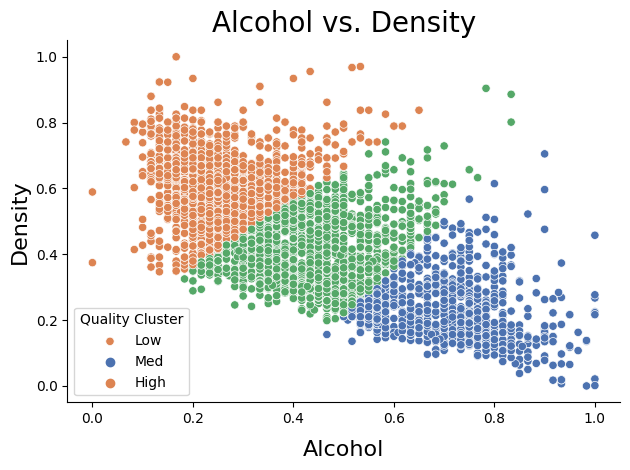

In [11]:
from vis import qual_cluster
qual_cluster(train)

<font size="4"> **Hypothesis 3: Cluster Impact**</font>
   <font size="3"> 
   
   - *Question:* `Does the new cluster feature impact wine Quality?`
   </font>

H0: There is no significant association between the quality of the wine and the Alcohol/Density Cluster.

Ha: There is a significant association between the quality of the wine and the Alcohol/Density Cluster.

In [12]:
from explore import perform_chi2_test

perform_chi2_test(train, 'alc_dens_cluster', 'quality')

Chi-Squared Test of Independence:
Chi-Squared Statistic: 919.5566
P-value: 0.0000


<font size="5">We `REJECT` the null hypothesis.</font><br>
<font size="4">`There is` a significant association between `Quality` of the wine and the `Alcohol/Density Cluster`.</font>

___
<font size="5">Exploration Summary</font><br>
___

We performed `Spearman's` test on: 

 - Alcohol
 - Density
 - Volatile Acidity
 - Alcohol + Density Cluster
 
 `All indicated a relationship`


<font size="5">Feature Engineering</font><br>

2 additional columns:
- *`'type'`*: Red or White from the made from the separate original csv files.
- *`'alc_dens_cluster'`*: Alcohol + Density Cluster categorical feature.

We performed feature selection using:
 
- `SelectKbest`
- `RFE`
- `LASSO`

In [13]:
feature_selections_results(train, 'quality', 4)

,Kbest,RFE,Lasso
0,alcohol,volatile_acidity,free_sulfur_dioxide
1,density,chlorides,total_sulfur_dioxide
2,volatile_acidity,density,fixed_acidity
3,chlorides,sulphates,volatile_acidity


____
____
## MODELING
____
____

- I will use the Root Mean Squared Error `(RMSE)` as my evaluation metric for regression models.
- Models will be `evaluated on train and validate` data
- Baseline RMSE is `0.88` on train data
- The model that performs the best will then be evaluated on test data


<font size="3">Preprocesses for machine learning by: </font><br><br>

- Split:
    - 70% training set
    - 15% validation set
    - 15% test set.
<br>
<br>
- Separates features (X) and labels (y) for the training and validation sets
- Scaling using Min-Max.
<br><br>



___
### Stablish a baseline
___

In [14]:
# Split df into train, validat and test dataframes 
# Split further into X and Y dataframes respectively 
X_train, y_train, X_val, y_val, X_test, y_test = data_pipeline()

Calculate the Root Mean Squared Error `(RMSE)` between actual target values and baseline predictions. <br>
The baseline prediction is computed as the `mean` of the actual target values (y_train).

In [15]:
# Calculate baseline using mean
eval_baseline(y_train)

0.8747

<font size="4">Baseline `0.88`</font>

____
### ALPHA Feature Set
____

- Original 12 features
- Wine type feature
- `Not scaled`


<font size="4">Random Forest</font><br><br>


In [16]:
rforest, alpha = train_model(RandomForestRegressor, X_train, y_train, X_val, y_val)

The train RMSE is 0.23.
The validate RMSE is 0.66.


<font size="4">XGBoost</font><br><br>


In [17]:
xgbr, alpha = train_model(XGBRegressor, X_train, y_train, X_val, y_val, alpha)

The train RMSE is 0.24.
The validate RMSE is 0.69.


<font size="4">`RMSE Results` for Alpha feature set</font><br><br>

In [18]:
# Show Alpha Models results table
alpha

,Model,Train_RMSE,Val_RMSE
0,RandomForestRegressor,0.23,0.66
1,XGBRegressor,0.24,0.69


____
### BRAVO Feature Set
____

- Original 12 features
- Wine type feature
- `MinMax scaled`
- `Alcohol+Density Cluster Feature`


In [19]:
# Split df into train, validat and test dataframes 
# Split further into X and Y dataframes respectively 
X_train, y_train, X_val, y_val, X_test, y_test = bravo_pipeline()

<font size="4">LinearRegression</font><br><br>


In [20]:
linearr, bravo = train_model(LinearRegression, X_train, y_train, X_val, y_val)

The train RMSE is 0.73.
The validate RMSE is 0.77.


In [21]:
bravo

,Model,Train_RMSE,Val_RMSE
0,LinearRegression,0.73,0.77


____
### `Hyperparameters`
____
####  ALPHA RandomForestRegressor 



In [22]:
rforest, alpha = train_hyper(RandomForestRegressor, X_train, y_train, X_val, y_val,)

The train RMSE is 0.23.
The validate RMSE is 0.64.


<font size="5">Comparing Models</font><br><br>

 - XGBoos, LinearRegression and RandomForestRegressor models all performed better than baseline.
 - I have chosen to move forward with the `RandomForestRegressor` model with `hyperparameters` as it had a the best predictive performance.

<font size="5">Random Forest Regresor on Test Data</font><br><br>

In [23]:
test_alpha = test_model(rforest, X_test, y_test)

The test RMSE is 0.59.


<font size="4">Final RMSE on Test data `0.59`</font><br><br>

<font size="5">Modeling Summary</font><br><br>

 - `RandomForestRegressor model scored RMSE 0.59` compared to the `baseline of 0.88`, it had an improvement of aprox $0.29 RMSE.

<font size="5">Conclusions</font><br><br>

 - Found a stron relationship between Alcohol, Density, Volatile Acidity and Alcohol + Density Cluster to the Quality of the wines.
 - Engineered 2 new columns.
   - *'type'*
   - *'alc_dens_cluster'*
<br><br>

 - Performed feature selection to find top features:
   - free_sulfur_dioxide
   - chlorides
   - total_sulfur_dioxide
   - volatile_acidity
   - sulphates
   - fixed_acidity 
<br><br>

 - The final model significantly out performed the baseline.

<font size="5">Recommendations</font><br><br>

 - Feature engineered 
      - Using ratios between original features
      - Using clusters to create new categorical features